# 0. Problem Identification

When readers choose books, they are influenced by different factors such as the type of book, author, publisher, price, whether it is recommended by editors, whether it is a popular book, and other readers' reviews. How can we recommend suitable books to different types of readers?
Build a recommendation model based on content similarity or clustering to provide personalized book recommendations to readers. 

# 1. Setup and Initialization

In [1]:
# Importing Necessary Libraries

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from tabulate import tabulate
from collections import Counter

%matplotlib inline

In [2]:
# Initialize Plotly for use in the notebook
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

# Configure Seaborn plot styles: Set background color and use dark grid
sns.set(rc={'axes.facecolor': '#fcf0dc'}, style='darkgrid')

In [3]:
# Loading the Dataset

df = pd.read_csv('kindle_data-v2.csv')

Dataset Description

asin
Product ID from Amazon. (type: str)

title
Title of the book. (type: str)

author
Author(s) of the book. (type: str)

soldBy
Seller(s) of the book. (type: str)

imgUrl
URL of the book cover image. (type: str)

productURL
URL of the book. (type: str)

stars
Average rating of the book. If 0, no ratings were found. (type: float)

reviews
Number of reviews. If 0, no reviews were found. (type: int)

price
Price of the book. If 0, price was unavailable. (type: float)

isKindleUnlimited
Whether the book is available through Kindle Unlimited. (type: bool)

category_id
Serial id assigned to the category this book belong to. (type: int)

isBestSeller
Whether the book had the Amazon Best Seller status or not. (type: bool)

isEditorsPick
Whether the book had the Editor's Pick status or not. (type: bool)

isGoodReadsChoice
Whether the book had the Goodreads Choice status or not. (type: bool)

publishedDate
Publication date of the book. (type: str, format: YYY-YMM-DD)

category_name
Name of the book category. (type: str)

In [4]:
# Initial Data Analysis
df.head(10)

asin                                              title  \
0  B00TZE87S4  Adult Children of Emotionally Immature Parents...   
1  B08WCKY8MB  From Strength to Strength: Finding Success, Ha...   
2  B09KPS84CJ  Good Inside: A Guide to Becoming the Parent Yo...   
3  B07S7QPG6J             Everything I Know About Love: A Memoir   
4  B00N6PEQV0  The Seven Principles for Making Marriage Work:...   
5  B000OVLKMM                         The Glass Castle: A Memoir   
6  B00AEBEQUK  Expecting Better: Why the Conventional Pregnan...   
7  B0BN5742KY  Never Enough: When Achievement Culture Becomes...   
8  B098PXH8CK  Unmasking Autism: Discovering the New Faces of...   
9  B087D5YQXB  What Happened to You?: Conversations on Trauma...   

                     author                                soldBy  \
0         Lindsay C. Gibson               Amazon.com Services LLC   
1          Arthur C. Brooks               Penguin Group (USA) LLC   
2             Becky Kennedy              HarperCollins Publishers   
3            Dolly Alderton              HarperCollins Publishers   
4              John Gottman                      Random House LLC   
5           Jeannette Walls  Simon and Schuster Digital Sales Inc   
6               Emily Oster               Penguin Group (USA) LLC   
7  Jennifer Breheny Wallace               Penguin Group (USA) LLC   
8               Devon Price                      Random House LLC   
9             Oprah Winfrey                             Macmillan   

                                              imgUrl  \
0  https://m.media-amazon.com/images/I/713KZTsaYp...   
1  https://m.media-amazon.com/images/I/A1LZcJFs9E...   
2  https://m.media-amazon.com/images/I/71RIWM0sv6...   
3  https://m.media-amazon.com/images/I/71QdQpTiKZ...   
4  https://m.media-amazon.com/images/I/813o4WOs+w...   
5  https://m.media-amazon.com/images/I/71td5GDUZM...   
6  https://m.media-amazon.com/images/I/81NYWaTY6-...   
7  https://m.media-amazon.com/images/I/816Sqs9RUu...   
8  https://m.media-amazon.com/images/I/81aqifI4AZ...   
9  https://m.media-amazon.com/images/I/713XUMrojk...   

                             productURL  stars  reviews  price  \
0  https://www.amazon.com/dp/B00TZE87S4    4.8        0   9.99   
1  https://www.amazon.com/dp/B08WCKY8MB    4.4        0  16.99   
2  https://www.amazon.com/dp/B09KPS84CJ    4.8        0  16.99   
3  https://www.amazon.com/dp/B07S7QPG6J    4.2        0   9.95   
4  https://www.amazon.com/dp/B00N6PEQV0    4.7        0  13.99   
5  https://www.amazon.com/dp/B000OVLKMM    4.6        0  13.99   
6  https://www.amazon.com/dp/B00AEBEQUK    4.6        0  14.99   
7  https://www.amazon.com/dp/B0BN5742KY    4.6        0  15.99   
8  https://www.amazon.com/dp/B098PXH8CK    4.7        0  12.99   
9  https://www.amazon.com/dp/B087D5YQXB    4.7        0  14.99   

   isKindleUnlimited  category_id  isBestSeller  isEditorsPick  \
0              False            6          True          False   
1              False            6         False          False   
2              False            6         False           True   
3               True            6         False           True   
4              False            6         False          False   
5              False            6         False          False   
6              False            6          True          False   
7              False            6         False           True   
8              False            6          True          False   
9               True            6         False           True   

   isGoodReadsChoice publishedDate              category_name  
0              False    2015-06-01  Parenting & Relationships  
1              False    2022-02-15  Parenting & Relationships  
2              False    2022-09-13  Parenting & Relationships  
3              False    2020-02-25  Parenting & Relationships  
4              False    2015-05-05  Parenting & Relationships  
5              False    2005-03-01  Parenting

In [5]:
df.tail(10)

asin                                              title  \
133092  0142417823                                         The Batboy   
133093  B0C9MJNKY3  The Dream: The Extraordinary Revelation Of Who...   
133094  B08WRF7W4Z  Killers of the Flower Moon: Adapted for Young ...   
133095  B09V1T7V5C                               THE EYES OF DARKNESS   
133096  B08BR2HFWJ           Everything Sad Is Untrue: (a true story)   
133097  B0C3SJDLK8                                      Anna Karenina   
133098  B09DW752Y1  Scary Smart: Scary Smart: The Future of Artifi...   
133099  B0CFWHPJTN  The Count of Monte Cristo: The Original Unabri...   
133100  B0C1KMFXJC                                      War And Peace   
133101  B0BS1KYZB6                                Pride and Prejudice   

                 author                   soldBy  \
133092      Mike Lupica                      NaN   
133093       David Icke  Amazon.com Services LLC   
133094      David Grann         Random House LLC   
133095      Dean Koontz  Amazon.com Services LLC   
133096    Daniel Nayeri  Amazon.com Services LLC   
133097      Leo Tolstoy                De Marque   
133098        Mo Gawdat  Amazon.com Services LLC   
133099  Alexandre Dumas                De Marque   
133100      Leo Tolstoy                De Marque   
133101      Jane Austen                De Marque   

                                                   imgUrl  \
133092  https://m.media-amazon.com/images/I/816zv4T0x+...   
133093  https://m.media-amazon.com/images/I/91yWEsUH3C...   
133094  https://m.media-amazon.com/images/I/91izoAqUX+...   
133095  https://m.media-amazon.com/images/I/912K8zHSK5...   
133096  https://m.media-amazon.com/images/I/918XenxAQU...   
133097  https://m.media-amazon.com/images/I/61RXEyMctk...   
133098  https://m.media-amazon.com/images/I/71tjf6R-Wa...   
133099  https://m.media-amazon.com/images/I/71zcCb5Pvu...   
133100  https://m.media-amazon.com/images/I/715QpZlzmi...   
133101  https://m.media-amazon.com/images/I/81Scutrtj4...   

                                  productURL  stars  reviews  price  \
133092  https://www.amazon.com/dp/0142417823    4.7        0   7.99   
133093  https://www.amazon.com/dp/B0C9MJNKY3    4.5        0   7.99   
133094  https://www.amazon.com/dp/B08WRF7W4Z    4.6        0   9.99   
133095  https://www.amazon.com/dp/B09V1T7V5C    4.4        0   9.99   
133096  https://www.amazon.com/dp/B08BR2HFWJ    4.6        0   8.80   
133097  https://www.amazon.com/dp/B0C3SJDLK8    4.7        0   0.00   
133098  https://www.amazon.com/dp/B09DW752Y1    4.4        0   9.99   
133099  https://www.amazon.com/dp/B0CFWHPJTN    4.8        0   1.99   
133100  https://www.amazon.com/dp/B0C1KMFXJC    4.7        0   0.00   
133101  https://www.amazon.com/dp/B0BS1KYZB6    4.7        0   0.00   

        isKindleUnlimited  category_id  isBestSeller  isEditorsPick  \
133092              False           25         False          False   
133093              False           29         False          False   
133094              False           29         False           True   
133095               True           29         False          False   
133096              False           29         False          False   
133097              False           29          True          False   
133098              False           29         False          False   
133099              False           29          True          False   
133100              False           29          True          False   
133101              False           29         False          False   

        isGoodReadsChoice publishedDate      category_name  
133092              False    2011-02-22  Children's eBooks  
133093              False    2023-09-01         Nonfiction  
133094              False    2021-11-16         Nonfiction  
133095              False    2022-03-05         Nonfiction  
133096              False    2020-08-25         Nonfiction  
133097              False    2023-0

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133102 entries, 0 to 133101
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   asin               133102 non-null  object 
 1   title              133102 non-null  object 
 2   author             132677 non-null  object 
 3   soldBy             123869 non-null  object 
 4   imgUrl             133102 non-null  object 
 5   productURL         133102 non-null  object 
 6   stars              133102 non-null  float64
 7   reviews            133102 non-null  int64  
 8   price              133102 non-null  float64
 9   isKindleUnlimited  133102 non-null  bool   
 10  category_id        133102 non-null  int64  
 11  isBestSeller       133102 non-null  bool   
 12  isEditorsPick      133102 non-null  bool   
 13  isGoodReadsChoice  133102 non-null  bool   
 14  publishedDate      84086 non-null   object 
 15  category_name      133102 non-null  object 
dtypes:

In [7]:
df.imgUrl

0         https://m.media-amazon.com/images/I/713KZTsaYp...
1         https://m.media-amazon.com/images/I/A1LZcJFs9E...
2         https://m.media-amazon.com/images/I/71RIWM0sv6...
3         https://m.media-amazon.com/images/I/71QdQpTiKZ...
4         https://m.media-amazon.com/images/I/813o4WOs+w...
                                ...                        
133097    https://m.media-amazon.com/images/I/61RXEyMctk...
133098    https://m.media-amazon.com/images/I/71tjf6R-Wa...
133099    https://m.media-amazon.com/images/I/71zcCb5Pvu...
133100    https://m.media-amazon.com/images/I/715QpZlzmi...
133101    https://m.media-amazon.com/images/I/81Scutrtj4...
Name: imgUrl, Length: 133102, dtype: object

In [8]:
print(df.imgUrl[3])

https://m.media-amazon.com/images/I/71QdQpTiKZL._AC_UY218_.jpg


# 2. Summary Statistics

In [9]:
df.describe().T

count        mean          std  min   25%    50%     75%  \
stars        133102.0    4.404090     0.745646  0.0  4.40   4.50    4.70   
reviews      133102.0  887.375779  5104.878777  0.0  0.00   4.00  365.00   
price        133102.0   15.134127    22.254986  0.0  4.99   9.99   14.99   
category_id  133102.0   16.287111     8.416924  1.0  9.00  16.00   23.00   

                  max  
stars             5.0  
reviews      618227.0  
price           682.0  
category_id      31.0

In [10]:
df.describe(include=object).T

count  unique  \
asin           133102  133102   
title          133102  131913   
author         132677   72805   
soldBy         123869      49   
imgUrl         133102  132909   
productURL     133102  133102   
publishedDate   84086    7157   
category_name  133102      31   

                                                             top   freq  
asin                                                  B00TZE87S4      1  
title                                          Organic Chemistry      8  
author                                           James Patterson    212  
soldBy                                   Amazon.com Services LLC  84759  
imgUrl         https://m.media-amazon.com/images/I/01RmK+J4pJ...    105  
productURL                  https://www.amazon.com/dp/B00TZE87S4      1  
publishedDate                                         2023-09-12    347  
category_name                       Mystery, Thriller & Suspense   6272

In [11]:
df.stars.unique()

array([4.8, 4.4, 4.2, 4.7, 4.6, 4.5, 3.9, 5. , 4.3, 4.1, 4.9, 4. , 3.7,
       0. , 3.4, 3. , 3.8, 3.5, 3.6, 2. , 2.9, 1.8, 2.7, 2.3, 3.3, 2.6,
       2.5, 1. , 3.2, 2.8, 3.1, 2.2, 1.5, 1.6, 2.4, 1.9, 2.1, 1.7])

In [12]:
df.stars.value_counts()

4.6    24163
4.5    22367
4.7    20049
4.4    16214
4.8    11730
4.3    10629
4.2     6337
5.0     4822
4.1     3679
4.9     3329
0.0     3182
4.0     2531
3.9     1309
3.8      829
3.7      484
3.6      347
3.5      287
3.0      185
3.4      131
3.3      111
1.0       83
3.2       62
2.0       49
3.1       48
2.9       34
2.5       22
2.7       21
2.6       16
2.8       16
2.3        8
2.4        7
2.2        5
1.8        4
1.5        3
1.6        3
2.1        3
1.9        2
1.7        1
Name: stars, dtype: int64

In [13]:
df.reviews.unique()

array([    0, 31767, 10325, ...,  4944, 13498, 13930], dtype=int64)

In [14]:
df.reviews.value_counts()

0        64670
1          695
2          515
3          458
4          421
         ...  
8756         1
7109         1
1715         1
68915        1
13930        1
Name: reviews, Length: 8441, dtype: int64

In [15]:
df.reviews

0         0
1         0
2         0
3         0
4         0
         ..
133097    0
133098    0
133099    0
133100    0
133101    0
Name: reviews, Length: 133102, dtype: int64

In [16]:
df.sort_values(by='publishedDate')

asin                                              title  \
130517  B01K3LK4KG  Percy Jackson's Greek Gods by Rick Riordan (20...   
130547  0007528094  The Chronicles of Narnia box set (The Chronicl...   
15526   B004HYFO3S      Chimpanzee Politics: Power and Sex among Apes   
130288  044808905X    Hunting for Hidden Gold (The Hardy Boys, No. 5)   
130062  0448089068             The Shore Road Mystery (Hardy Boys #6)   
...            ...                                                ...   
133053  1398521337                                        UNTITLED AR   
133062  B003VXKBKW             Coot Club: Swallows and Amazons Series   
133063  0702301825                                Rick A George Novel   
133075  B002EDTV7Y  Star Wars: Jedi Quest, Book 1: The Way of the ...   
133079  B001KW7NZM     In the Belly of the Bloodhound: Bloody Jack #4   

                   author                   soldBy  \
130517                NaN                      NaN   
130547                NaN                      NaN   
15526    Frans de de Waal  Amazon.com Services LLC   
130288  Franklin W. Dixon                      NaN   
130062  Franklin W. Dixon                      NaN   
...                   ...                      ...   
133053                NaN                      NaN   
133062     Arthur Ransome                      NaN   
133063                NaN                      NaN   
133075        Jude Watson                      NaN   
133079        L. A. Meyer                      NaN   

                                                   imgUrl  \
130517  https://m.media-amazon.com/images/I/51ARIl1BoW...   
130547  https://m.media-amazon.com/images/I/71DFdflf0D...   
15526   https://m.media-amazon.com/images/I/51yTzBRTxD...   
130288  https://m.media-amazon.com/images/I/71diufh-B-...   
130062  https://m.media-amazon.com/images/I/71Q6uFPR9E...   
...                                                   ...   
133053  https://m.media-amazon.com/images/I/71KmoypWPE...   
133062  https://m.media-amazon.com/images/I/81R1yn9bw2...   
133063  https://m.media-amazon.com/images/I/41HkgasrL4...   
133075  https://m.media-amazon.com/images/I/81jriAXVf0...   
133079  https://m.media-amazon.com/images/I/518xa5L1iS...   

                                  productURL  stars  reviews  price  \
130517  https://www.amazon.com/dp/B01K3LK4KG    4.8        0  14.90   
130547  https://www.amazon.com/dp/0007528094    4.8        0  88.59   
15526   https://www.amazon.com/dp/B004HYFO3S    4.7        0  24.49   
130288  https://www.amazon.com/dp/044808905X    4.5        0   6.46   
130062  https://www.amazon.com/dp/0448089068    4.6        0   9.99   
...                                      ...    ...      ...    ...   
133053  https://www.amazon.com/dp/1398521337    4.8        0  21.84   
133062  https://www.amazon.com/dp/B003VXKBKW    4.6        0   0.00   
133063  https://www.amazon.com/dp/0702301825    4.7        0   6.28   
133075  https://www.amazon.com/dp/B002EDTV7Y    4.4        0   0.00   
133079  https://www.amazon.com/dp/B001KW7NZM    4.8        0   0.00   

        isKindleUnlimited  category_id  isBestSeller  isEditorsPick  \
130517              False           25         False          False   
130547              False           25         False          False   
15526               False           15         False          False   
130288              False           25         False          False   
130062              False           25         False          False   
...                   ...          ...           ...            ...   
133053              False           25         False          False   
133062              False           25         False          False   
133063              False           25         False           True   
133075               True           25         False          False   
133079              False           25         False          False   

        isGoodReadsChoice publishedDate      cate

# 3. Data Cleaning

In [17]:
# Handling Missing Values

# Check for NaN values
print("\nNaN values in the DataFrame:")
print(df.isnull().sum())


NaN values in the DataFrame:
asin                     0
title                    0
author                 425
soldBy                9233
imgUrl                   0
productURL               0
stars                    0
reviews                  0
price                    0
isKindleUnlimited        0
category_id              0
isBestSeller             0
isEditorsPick            0
isGoodReadsChoice        0
publishedDate        49016
category_name            0
dtype: int64


In [18]:
df['reviews'].value_counts().index

Int64Index([    0,     1,     2,     3,     4,     5,     8,     6,    10,
                7,
            ...
            32523, 62202, 11452, 47264,  4841,  8756,  7109,  1715, 68915,
            13930],
           dtype='int64', length=8441)

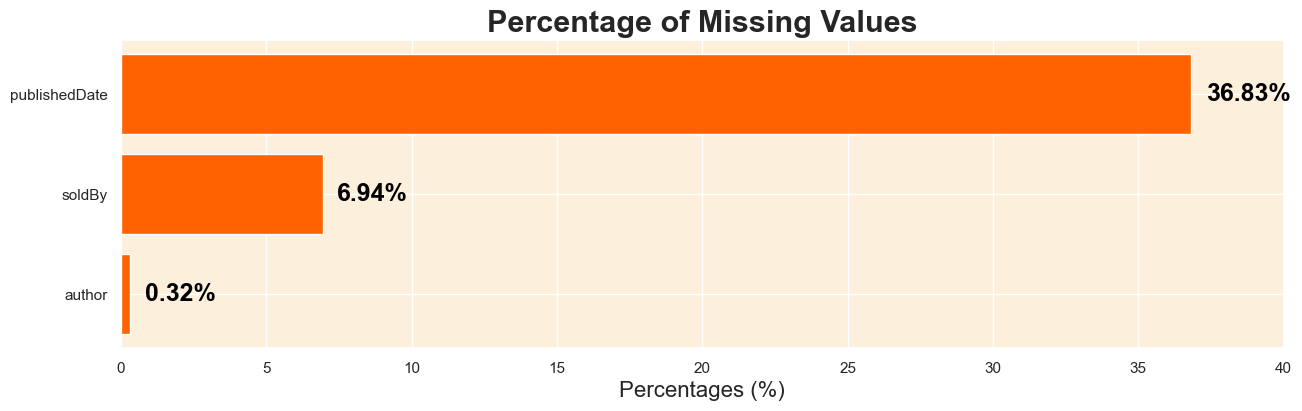

In [19]:
# Calculating the percentage of missing values for each column
missing_data = df.isnull().sum()
missing_percentage = (missing_data[missing_data > 0] / df.shape[0]) * 100

# Prepare values
missing_percentage.sort_values(ascending=True, inplace=True)

# Plot the barh chart
fig, ax = plt.subplots(figsize=(15, 4))
ax.barh(missing_percentage.index, missing_percentage, color='#ff6200')

# Annotate the values and indexes
for i, (value, name) in enumerate(zip(missing_percentage, missing_percentage.index)):
    ax.text(value+0.5, i, f"{value:.2f}%", ha='left', va='center', fontweight='bold', fontsize=18, color='black')

# Set x-axis limit
ax.set_xlim([0, 40])

# Add title and xlabel
plt.title("Percentage of Missing Values", fontweight='bold', fontsize=22)
plt.xlabel('Percentages (%)', fontsize=16)
plt.show()


In [20]:
# Extracting rows with missing values in 'author' or 'soldBy' columns
df[df['author'].isnull() | df['soldBy'].isnull()].head()

asin                                              title  \
32   B09RX42621  It Starts with Us: the highly anticipated sequ...   
33   B017RNBS3A  It Ends With Us: The emotional #1 Sunday Times...   
99   B00BAJ2MYM  How to Talk to Anyone: 92 Little Tricks for Bi...   
100  B09FQDH5HZ  Seven Husbands of Evelyn Hugo: The Sunday Time...   
157  B096LZDY32          Stolen Focus: Why You Can't Pay Attention   

                  author soldBy  \
32        Colleen Hoover    NaN   
33        Colleen Hoover    NaN   
99          Leil Lowndes    NaN   
100  Taylor Jenkins Reid    NaN   
157          Johann Hari    NaN   

                                                imgUrl  \
32   https://m.media-amazon.com/images/I/81G91BUSHs...   
33   https://m.media-amazon.com/images/I/817vqET828...   
99   https://m.media-amazon.com/images/I/716i2nRD6T...   
100  https://m.media-amazon.com/images/I/71QeZB033Y...   
157  https://m.media-amazon.com/images/I/712SQSzvDh...   

                               productURL  stars  reviews  price  \
32   https://www.amazon.com/dp/B09RX42621    4.5        0    0.0   
33   https://www.amazon.com/dp/B017RNBS3A    4.7        0    0.0   
99   https://www.amazon.com/dp/B00BAJ2MYM    4.5        0    0.0   
100  https://www.amazon.com/dp/B09FQDH5HZ    4.6        0    0.0   
157  https://www.amazon.com/dp/B096LZDY32    4.5        0    0.0   

     isKindleUnlimited  category_id  isBestSeller  isEditorsPick  \
32               False            6         False           True   
33               False            6         False          False   
99               False            6         False          False   
100              False            6         False           True   
157              False            6         False           True   

     isGoodReadsChoice publishedDate              category_name  
32               False    2022-10-18  Parenting & Relationships  
33                True    2016-08-02  Parenting & Relationships  
99               False    2013-03-07  Parenting & Relationships  
100              False    2021-10-14  Parenting & Relationships  
157              False    2022-01-06  Parenting & Relationships

In [21]:
df[df['author'].isnull() | df['soldBy'].isnull()].tail()

asin                                              title  \
133088  1338746758    Snow Day: A Graphic Novel (Mr. Wolf's Class #5)   
133089  1442428805          A Solitary Blue (3) (The Tillerman Cycle)   
133090  B00HG1NG2U  Baby-sitters' European Vacation (Baby-Sitters ...   
133091  1524739030                                The Kingdom of Back   
133092  0142417823                                         The Batboy   

                   author soldBy  \
133088  Aron Nels Steinke    NaN   
133089      Cynthia Voigt    NaN   
133090                NaN    NaN   
133091           Marie Lu    NaN   
133092        Mike Lupica    NaN   

                                                   imgUrl  \
133088  https://m.media-amazon.com/images/I/71aqgUvqiF...   
133089  https://m.media-amazon.com/images/I/61PpRfH0H2...   
133090  https://m.media-amazon.com/images/I/81OZRZPj+F...   
133091  https://m.media-amazon.com/images/I/A1mzDEOIGg...   
133092  https://m.media-amazon.com/images/I/816zv4T0x+...   

                                  productURL  stars  reviews  price  \
133088  https://www.amazon.com/dp/1338746758    4.7        0   8.49   
133089  https://www.amazon.com/dp/1442428805    4.6        0  11.99   
133090  https://www.amazon.com/dp/B00HG1NG2U    4.7        0   4.99   
133091  https://www.amazon.com/dp/1524739030    4.3        0  11.99   
133092  https://www.amazon.com/dp/0142417823    4.7        0   7.99   

        isKindleUnlimited  category_id  isBestSeller  isEditorsPick  \
133088              False           25         False          False   
133089              False           25         False          False   
133090              False           25         False          False   
133091              False           25         False          False   
133092              False           25         False          False   

        isGoodReadsChoice publishedDate      category_name  
133088              False    2022-04-05  Children's eBooks  
133089              False    2012-03-06  Children's eBooks  
133090              False    2022-08-17  Children's eBooks  
133091              False    2021-03-02  Children's eBooks  
133092              False    2011-02-22  Children's eBooks

In [22]:
# Convert the publishedDate column to datetime
df['publishedDate'] = pd.to_datetime(df['publishedDate'], errors='coerce')

# Find the minimum and maximum dates
min_date = df['publishedDate'].min()
max_date = df['publishedDate'].max()

# Display the results
print(f"Minimum publishedDate: {min_date}")
print(f"Maximum publishedDate: {max_date}")

Minimum publishedDate: 1806-01-01 00:00:00
Maximum publishedDate: 2024-01-16 00:00:00


In [23]:
# Find the minimum and maximum price
min_price = df['price'].min()
max_price = df['price'].max()

# Display the results
print(f"Minimum price: {min_price}")
print(f"Maximum price: {max_price}")

Minimum price: 0.0
Maximum price: 682.0


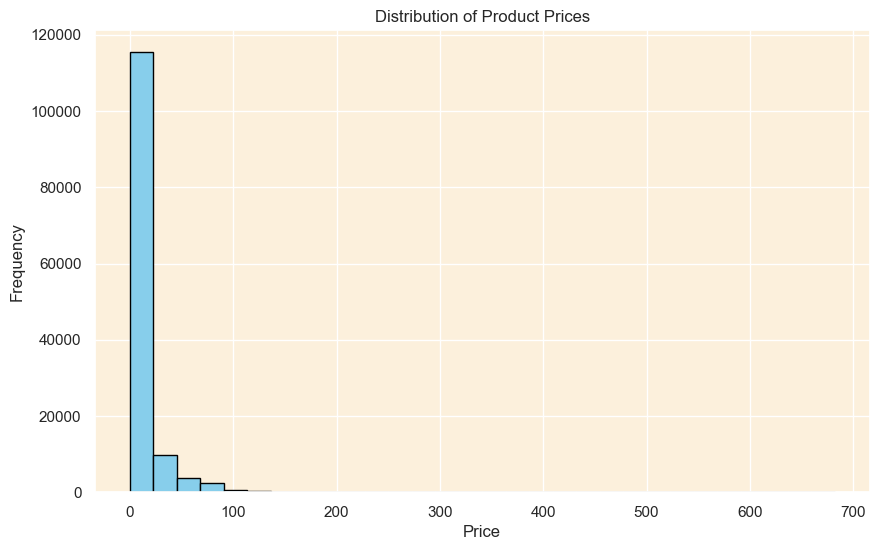

In [24]:
# Customized histogram for 'price'
df['price'].hist(bins=30, color='skyblue', edgecolor='black', figsize=(10, 6))
plt.title('Distribution of Product Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

In [25]:
# Extract the year from the prev_sold_date column
df['publishedYear'] = df['publishedDate'].dt.year

# Calculate the number of years between 2024 and the prev_sold_year
df['years_since_published'] = 2024 - df['publishedYear']

# Display the updated DataFrame
print(df[['publishedDate', 'publishedYear', 'years_since_published']].head())

  publishedDate  publishedYear  years_since_published
0    2015-06-01         2015.0                    9.0
1    2022-02-15         2022.0                    2.0
2    2022-09-13         2022.0                    2.0
3    2020-02-25         2020.0                    4.0
4    2015-05-05         2015.0                    9.0


In [26]:
# Calculate the mean of the years_since_sold column, ignoring NaN values
mean_years_since_published = df['years_since_published'].mean()

# Replace NaN values in the years_since_sold column with the calculated mean
df['years_since_published'].fillna(mean_years_since_published, inplace=True)

# Display the updated DataFrame
print(df[['publishedDate', 'publishedYear', 'years_since_published']].head())

  publishedDate  publishedYear  years_since_published
0    2015-06-01         2015.0                    9.0
1    2022-02-15         2022.0                    2.0
2    2022-09-13         2022.0                    2.0
3    2020-02-25         2020.0                    4.0
4    2015-05-05         2015.0                    9.0


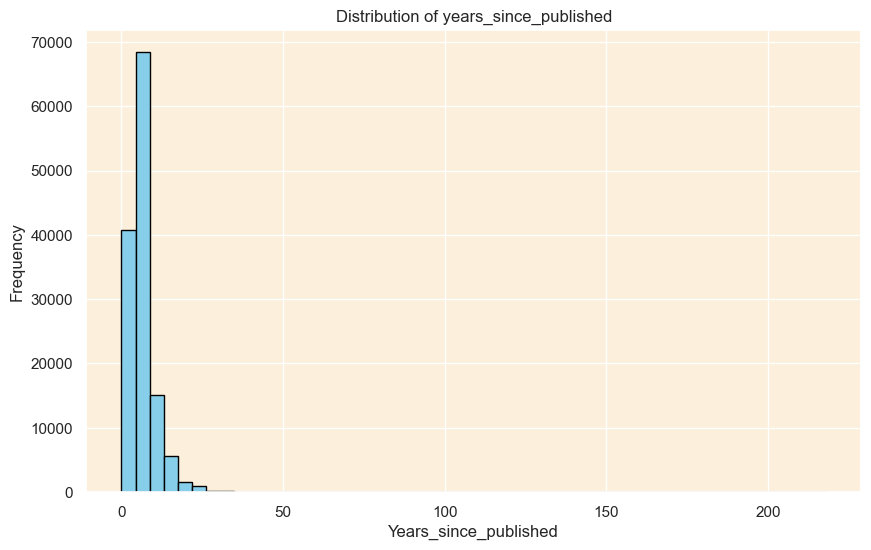

In [27]:
# Customized histogram for 'years_since_published'
df['years_since_published'].hist(bins=50, color='skyblue', edgecolor='black', figsize=(10, 6))
plt.title('Distribution of years_since_published')
plt.xlabel('Years_since_published')
plt.ylabel('Frequency')
plt.show()

In [28]:
df[df['publishedDate'].isnull()].head()

asin                                              title  \
6   B00AEBEQUK  Expecting Better: Why the Conventional Pregnan...   
10  B00AN2JPNI  Moms on Call | Basic Baby Care 0-6 Months | Pa...   
11  B0B69SQNJY    A Little Pinprick (Rainey Paxton Series Book 1)   
12  B07FZPTDJ3  Cribsheet: A Data-Driven Guide to Better, More...   
17  B0CBL7RV55  It Starts with the Egg: How the Science of Egg...   

              author                   soldBy  \
6        Emily Oster  Penguin Group (USA) LLC   
10  Laura Hunter LPN  Amazon.com Services LLC   
11      Paige Dearth  Amazon.com Services LLC   
12       Emily Oster  Penguin Group (USA) LLC   
17      Rebecca Fett  Amazon.com Services LLC   

                                               imgUrl  \
6   https://m.media-amazon.com/images/I/81NYWaTY6-...   
10  https://m.media-amazon.com/images/I/717AozsjVZ...   
11  https://m.media-amazon.com/images/I/71GoPR+P0e...   
12  https://m.media-amazon.com/images/I/81ck+JH5Ty...   
17  https://m.media-amazon.com/images/I/51Kr3Tkha1...   

                              productURL  stars  reviews  price  \
6   https://www.amazon.com/dp/B00AEBEQUK    4.6        0  14.99   
10  https://www.amazon.com/dp/B00AN2JPNI    4.7        0  24.99   
11  https://www.amazon.com/dp/B0B69SQNJY    4.6        0   5.99   
12  https://www.amazon.com/dp/B07FZPTDJ3    4.7        0  14.99   
17  https://www.amazon.com/dp/B0CBL7RV55    4.7        0   9.99   

    isKindleUnlimited  category_id  isBestSeller  isEditorsPick  \
6               False            6          True          False   
10              False            6         False          False   
11               True            6          True          False   
12              False            6         False          False   
17              False            6          True          False   

    isGoodReadsChoice publishedDate              category_name  publishedYear  \
6               False           NaT  Parenting & Relationships            NaN   
10              False           NaT  Parenting & Relationships            NaN   
11              False           NaT  Parenting & Relationships            NaN   
12              False           NaT  Parenting & Relationships            NaN   
17              False           NaT  Parenting & Relationships            NaN   

    years_since_published  
6                6.426088  
10               6.426088  
11               6.426088  
12               6.426088  
17               6.426088

In [29]:
# Replace NaN values in the author column with 'unknown'
df['author'].fillna('unknown', inplace=True)

In [30]:
# Replace NaN values in the soldBy column with 'no record'
df['soldBy'].fillna('no record', inplace=True)

In [31]:
df = df.drop(columns = ['publishedDate','publishedYear'])

In [32]:
# Check for NaN values
print("\nNaN values in the DataFrame:")
print(df.isnull().sum())


NaN values in the DataFrame:
asin                     0
title                    0
author                   0
soldBy                   0
imgUrl                   0
productURL               0
stars                    0
reviews                  0
price                    0
isKindleUnlimited        0
category_id              0
isBestSeller             0
isEditorsPick            0
isGoodReadsChoice        0
category_name            0
years_since_published    0
dtype: int64


In [33]:
df.shape

(133102, 16)

In [34]:
# Handling Duplicates

# Finding duplicate rows (keeping all instances)
duplicate_rows = df[df.duplicated(keep=False)]

# Sorting the data by certain columns to see the duplicate rows next to each other
duplicate_rows_sorted = duplicate_rows.sort_values(by=['asin', 'soldBy'])

# Displaying the first 10 records
duplicate_rows_sorted.head(10)


Empty DataFrame
Columns: [asin, title, author, soldBy, imgUrl, productURL, stars, reviews, price, isKindleUnlimited, category_id, isBestSeller, isEditorsPick, isGoodReadsChoice, category_name, years_since_published]
Index: []

In [35]:
# Find the maximum and minimum values for each numerical column
numerical_columns = ['stars', 'reviews', 'price', 'category_id','years_since_published']

# Create a dictionary to store the min and max values
min_max_values = {}

for column in numerical_columns:
    min_max_values[column] = {'min': df[column].min(), 'max': df[column].max()}

# Display the results
for column, values in min_max_values.items():
    print(f"{column}: Min = {values['min']}, Max = {values['max']}")

stars: Min = 0.0, Max = 5.0
reviews: Min = 0, Max = 618227
price: Min = 0.0, Max = 682.0
category_id: Min = 1, Max = 31
years_since_published: Min = 0.0, Max = 218.0


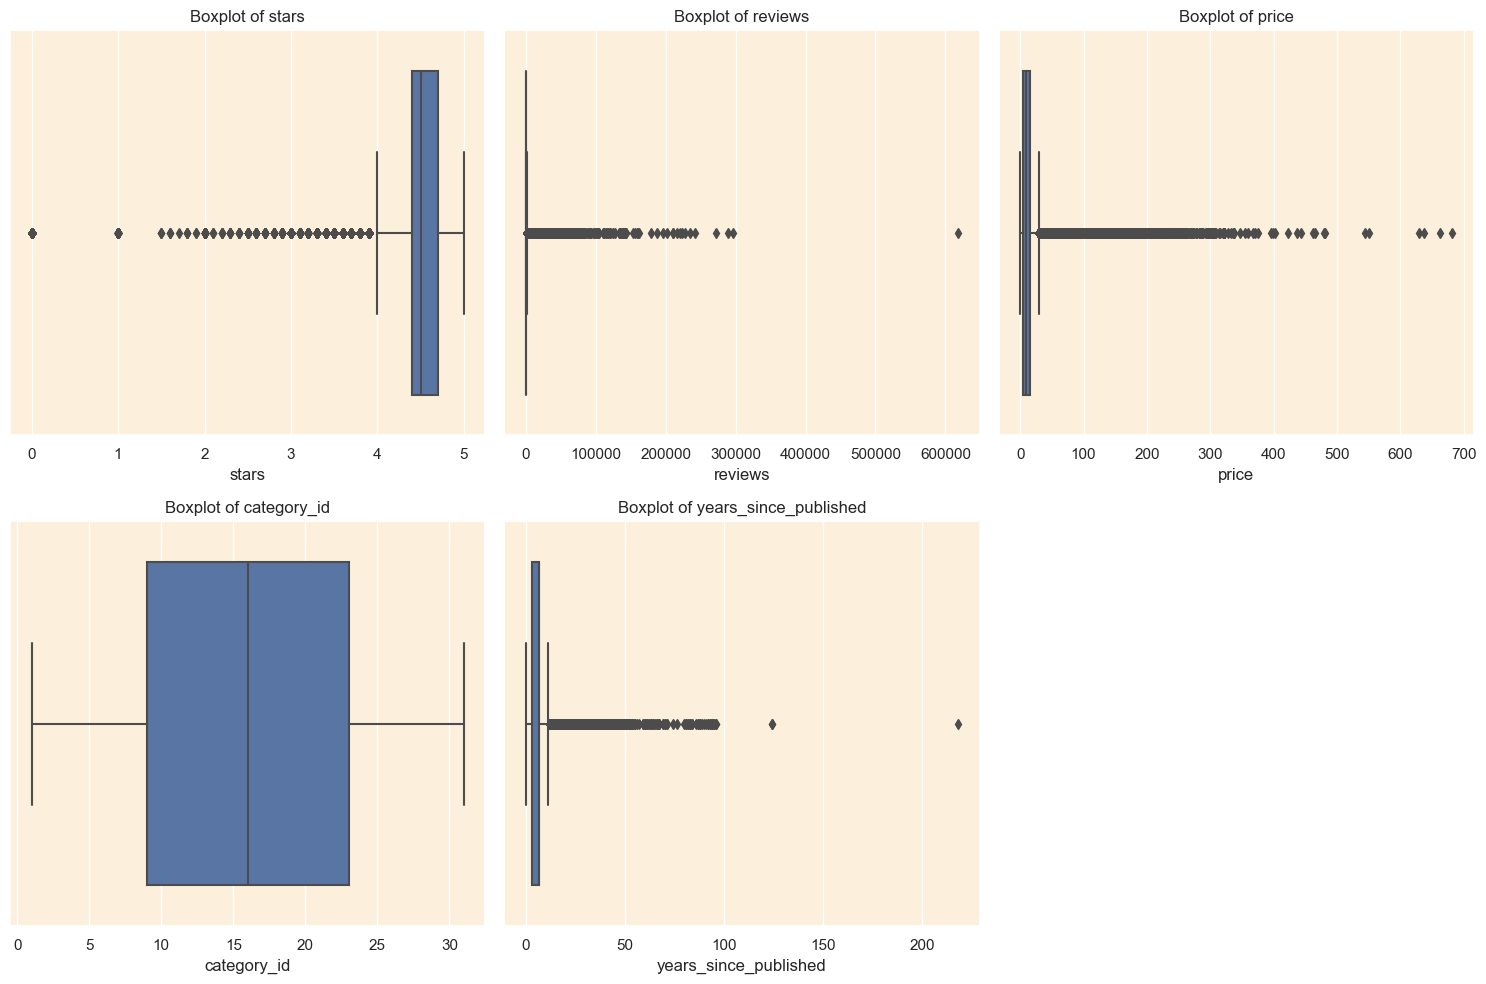

In [36]:
# List of numerical columns
numerical_columns = ['stars', 'reviews', 'price', 'category_id','years_since_published']

# Create a boxplot for each numerical column
plt.figure(figsize=(15, 10))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=df[column])
    plt.title(f'Boxplot of {column}')
    plt.xlabel(column)
plt.tight_layout()
plt.show()

In [37]:
# Identify and print abnormal values (outliers) for each numerical column
for column in numerical_columns:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    print(f"Abnormal values in {column}:")
    print(outliers[[column]])
    print("\n")

Abnormal values in stars:
        stars
18        3.9
59        3.9
216       3.7
557       3.9
588       0.0
...       ...
132878    0.0
132925    3.9
132945    2.0
133018    0.0
133076    3.9

[7252 rows x 1 columns]


Abnormal values in reviews:
       reviews
28600    31767
28601    10325
28602   219990
28603    69379
28604   124378
...        ...
98345     1624
98357     1665
98358     1476
98403     1204
98462     4076

[20876 rows x 1 columns]


Abnormal values in price:
        price
104     74.99
119     61.49
249     52.52
265     56.00
275     74.99
...       ...
132630  42.00
132711  59.99
132825  48.13
132855  74.19
132893  31.13

[13491 rows x 1 columns]


Abnormal values in category_id:
Empty DataFrame
Columns: [category_id]
Index: []


Abnormal values in years_since_published:
        years_since_published
5                        19.0
16                       13.0
20                       14.0
21                       18.0
26                       21.0
...             

In [38]:
# Function to remove outliers based on IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers for each numerical column
for column in numerical_columns:
    df = remove_outliers(df, column)

# Display the DataFrame after removing outliers
print(df.describe())

              stars       reviews         price   category_id  \
count  83384.000000  83384.000000  83384.000000  83384.000000   
mean       4.542400    128.777295      9.473114     16.795668   
std        0.222945    232.462492      5.670413      8.431920   
min        4.000000      0.000000      0.000000      1.000000   
25%        4.400000      0.000000      4.990000     10.000000   
50%        4.600000      0.000000      9.950000     18.000000   
75%        4.700000    149.000000     12.990000     24.000000   
max        5.000000   1019.000000     28.520000     31.000000   

       years_since_published  
count           83384.000000  
mean                5.181937  
std                 2.562599  
min                 0.000000  
25%                 3.000000  
50%                 6.426088  
75%                 6.426088  
max                11.000000  


In [39]:
missing = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1)
missing.columns=['count','%']
missing.sort_values(by='%')

count    %
asin                       0  0.0
title                      0  0.0
author                     0  0.0
soldBy                     0  0.0
imgUrl                     0  0.0
productURL                 0  0.0
stars                      0  0.0
reviews                    0  0.0
price                      0  0.0
isKindleUnlimited          0  0.0
category_id                0  0.0
isBestSeller               0  0.0
isEditorsPick              0  0.0
isGoodReadsChoice          0  0.0
category_name              0  0.0
years_since_published      0  0.0

In [40]:
df.to_csv('cleaned_file.csv', index=False)

# 4. data Exploratory Data Analysis

In [41]:
df=pd.read_csv('cleaned_file.csv',low_memory=False)

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83384 entries, 0 to 83383
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   asin                   83384 non-null  object 
 1   title                  83384 non-null  object 
 2   author                 83384 non-null  object 
 3   soldBy                 83384 non-null  object 
 4   imgUrl                 83384 non-null  object 
 5   productURL             83384 non-null  object 
 6   stars                  83384 non-null  float64
 7   reviews                83384 non-null  int64  
 8   price                  83384 non-null  float64
 9   isKindleUnlimited      83384 non-null  bool   
 10  category_id            83384 non-null  int64  
 11  isBestSeller           83384 non-null  bool   
 12  isEditorsPick          83384 non-null  bool   
 13  isGoodReadsChoice      83384 non-null  bool   
 14  category_name          83384 non-null  object 
 15  ye

In [43]:
df.shape

(83384, 16)

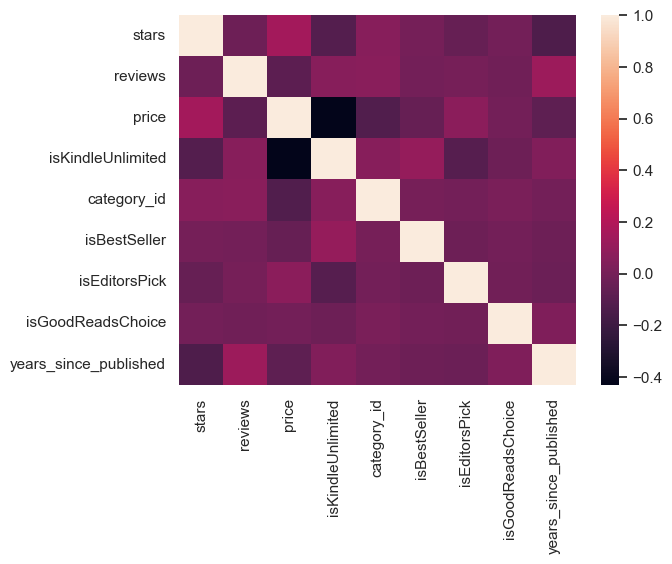

In [44]:
# Make a heatmap of the data 
correlation_matrix = df.corr()
_ = sns.heatmap(correlation_matrix)

In [45]:
df.set_index(['category_id']).groupby(['category_name']).mean()

stars     reviews      price  \
category_name                                                   
Arts & Photo graphy           4.562680  225.598657  11.508280   
Biographies & Memoirs         4.497712  361.329185  11.021939   
Business & Money              4.584477    0.000000  12.080674   
Children's eBooks             4.662827    0.000000   7.425144   
Comics                        4.562953  250.420613  11.264067   
Computers & Technology        4.528142  134.134622  13.878772   
Cookbooks, Food & Wine        4.568589   40.852367  10.219838   
Crafts, Hobbies & Home        4.579469   10.476770  10.126726   
Education & Teaching          4.554720  160.637981  12.670788   
Engineering & Transportation  4.504660    0.000000  11.549106   
Foreign Language              4.524285  288.674160   8.027735   
Health, Fitness & Dieting     4.594404    0.000000  10.891074   
History                       4.502002  308.563969  10.683412   
Humor & Entertainment         4.480247    0.000000   6.909254   
LGBTQ+ eBooks                 4.466325  371.462385   5.744629   
Law                           4.550354    0.000000  11.909355   
Literature & Fiction          4.509356  378.543689   6.194007   
Medical                       4.574177    0.000000  12.999165   
Mystery, Thriller & Suspense  4.445836    0.009517   7.366234   
Nonfiction                    4.612431  344.160221  11.288149   
Parenting & Relationships     4.572875   18.654251   8.855103   
Politics & Social Sciences    4.552288  282.114898  12.138564   
Reference                     4.544103    0.000000  10.085210   
Religion & Spirituality       4.664152  364.545556   8.631412   
Romance                       4.485793    0.000000   5.264880   
Science & Math                4.557385    0.000000  11.939834   
Science Fiction & Fantasy     4.540369  393.567182   6.379138   
Self-Help                     4.623793  259.573276   9.767388   
Sports & Outdoors             4.532776    0.000000   9.815945   
Teen & Young Adult            4.530673  412.860616   6.810705   
Travel                        4.493602  169.333249   9.904562   

                              isKindleUnlimited  isBestSeller  isEditorsPick  \
category_name                                                                  
Arts & Photo graphy                    0.148385      0.014071       0.018868   
Biographies & Memoirs                  0.129265      0.026495       0.140104   
Business & Money                       0.139765      0.034632       0.012369   
Children's eBooks                      0.233238      0.027698       0.057815   
Comics                                 0.286908      0.000000       0.002786   
Computers & Technology                 0.233441      0.014680       0.005729   
Cookbooks, Food & Wine                 0.300426      0.012116       0.132152   
Crafts, Hobbies & Home                 0.290265      0.019912       0.005973   
Education & Teaching                   0.230211      0.014524       0.002905   
Engineering & Transportation           0.198532      0.016278       0.022981   
Foreign Language                       0.203442      0.006939       0.000000   
Health, Fitness & Dieting              0.203069      0.034296       0.024368   
History                                0.221062      0.028721       0.065274   
Humor & Entertainment                  0.531259      0.006751       0.023188   
LGBTQ+ eBooks                          0.704964      0.003071       0.014585   
Law                                    0.175950      0.009726       0.012821   
Literature & Fiction                   0.662842      0.074139       0.043248   
Medical                                0.172152      0.011814       0.021097   
Mystery, Thriller & Suspense           0.509687      0.017335       0.127124   
Nonfiction                             0.121547      0.063536       0.049724   
Parenting & Relationships              0.299518      0.014461       0.029798   
Politics & Social Sciences             0.083739

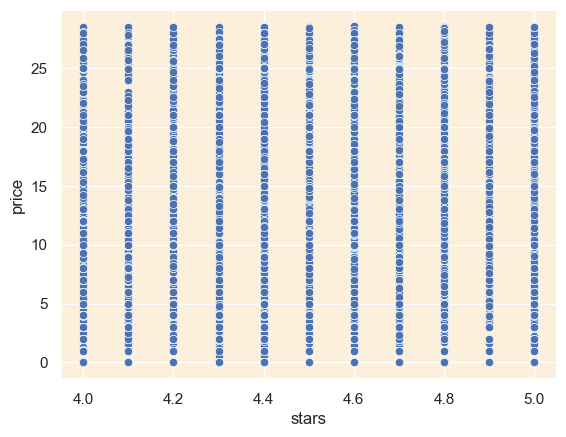

In [46]:
# Plot stars against price
_ = sns.scatterplot(x='stars', y='price', data=df)

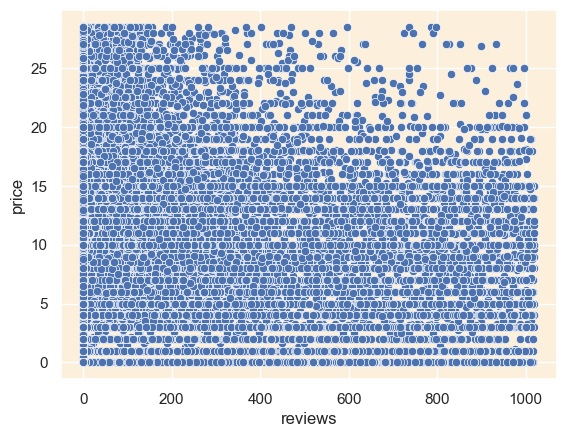

In [47]:
# Plot reviews against price
_ = sns.scatterplot(x='reviews', y='price', data=df)

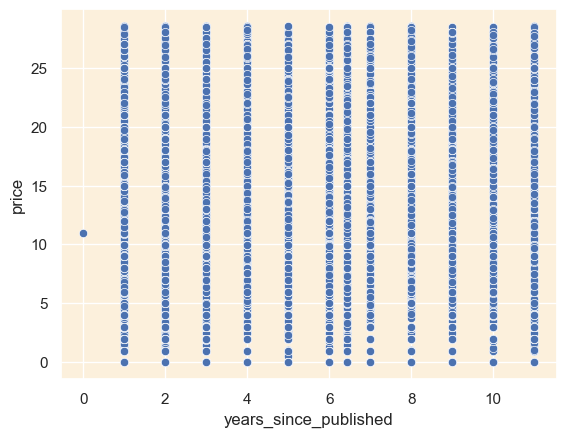

In [48]:
# Plot years_since_published against price
_ = sns.scatterplot(x='years_since_published', y='price', data=df)

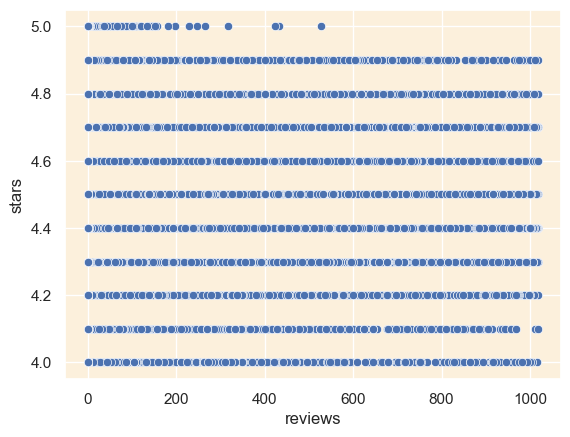

In [49]:
# Plot reviews against stars
_ = sns.scatterplot(x='reviews', y='stars', data=df)

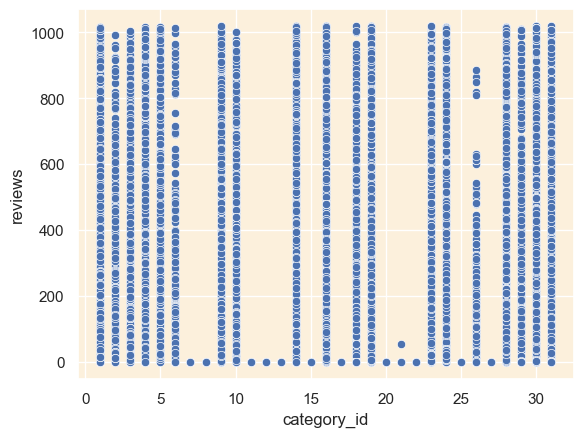

In [50]:
# Plot reviews against stars
_ = sns.scatterplot(x='category_id', y='reviews', data=df)

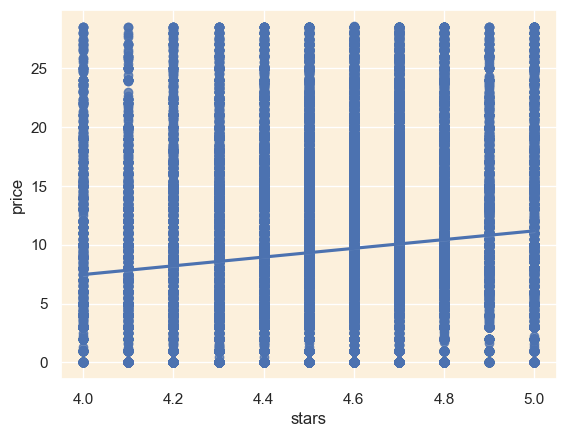

In [51]:
# Call the regplot method on the sns object, with parameters: x = 'stars', y = 'price'
_ = sns.regplot(x='stars', y='price', data=df)

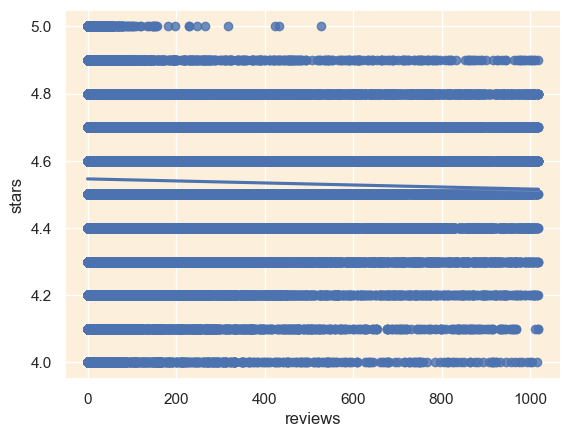

In [52]:
# Call the regplot method on the sns object, with parameters: x = 'reviews', y = 'stars'
_ = sns.regplot(x='reviews', y='stars', data=df)

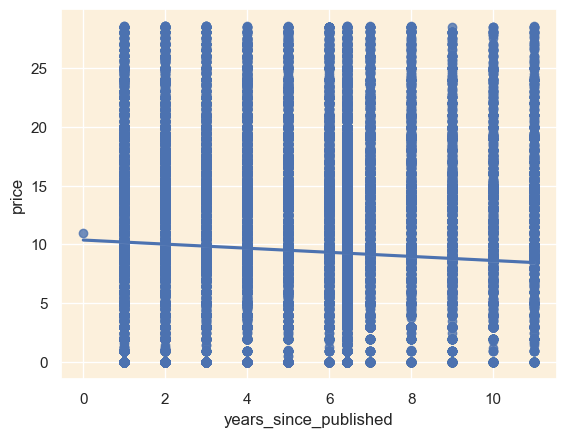

In [53]:
# Call the regplot method on the sns object, with parameters: x = 'years_since_published', y = 'price'
_ = sns.regplot(x='years_since_published', y='price', data=df)

# 5. Data Pre-processing

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83384 entries, 0 to 83383
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   asin                   83384 non-null  object 
 1   title                  83384 non-null  object 
 2   author                 83384 non-null  object 
 3   soldBy                 83384 non-null  object 
 4   imgUrl                 83384 non-null  object 
 5   productURL             83384 non-null  object 
 6   stars                  83384 non-null  float64
 7   reviews                83384 non-null  int64  
 8   price                  83384 non-null  float64
 9   isKindleUnlimited      83384 non-null  bool   
 10  category_id            83384 non-null  int64  
 11  isBestSeller           83384 non-null  bool   
 12  isEditorsPick          83384 non-null  bool   
 13  isGoodReadsChoice      83384 non-null  bool   
 14  category_name          83384 non-null  object 
 15  ye

In [55]:
# feature scaling

from sklearn.preprocessing import StandardScaler

# point numeric_columns
numeric_columns = ['stars', 'reviews', 'price', 'years_since_published']

# Select only the numeric columns for standardization
numeric_df = df[numeric_columns]

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the numeric data
scaled_features = scaler.fit_transform(numeric_df)

# Create a DataFrame with the scaled features
scaled_df = pd.DataFrame(scaled_features, columns=numeric_columns)

# Display the first few rows of the scaled DataFrame
print(scaled_df.head())

      stars   reviews     price  years_since_published
0  1.155446 -0.553974  0.091155               1.489927
1 -0.638726 -0.553974  1.325641              -1.241691
2  1.155446 -0.553974  1.325641              -1.241691
3 -1.535812 -0.553974  0.084101              -0.461229
4  0.706903 -0.553974  0.796576               1.489927


In [56]:
dummies_df = pd.get_dummies(df, columns=['author', 'soldBy', 'category_id','isKindleUnlimited', 'isBestSeller','isEditorsPick','isGoodReadsChoice'], drop_first=False)

dummies_df = dummies_df.drop(columns=['asin','title','imgUrl','productURL','category_name','stars','reviews','price','years_since_published'])

# Display the first few rows of the transformed DataFrame
print(dummies_df.head())

   author_"Termite" Terry Singleton  author_'El Pela' Gonzalo Romero  \
0                                 0                                0   
1                                 0                                0   
2                                 0                                0   
3                                 0                                0   
4                                 0                                0   

   author_(Chef) Dominique Ansel  author_(John D.) J. D. Turner  \
0                              0                              0   
1                              0                              0   
2                              0                              0   
3                              0                              0   
4                              0                              0   

   author_(Journalist) David Epstein  author_(Journalist) Leigh Gallagher  \
0                                  0                                    0   
1         

In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=1000) 
title_tfidf = tfidf.fit_transform(df['title'])

# Convert the TF-IDF matrix to a DataFrame
title_tfidf_df = pd.DataFrame(title_tfidf.toarray(), columns=tfidf.get_feature_names_out())

# Concatenate the new TF-IDF DataFrame with the original DataFrame
df_scaled = pd.concat([title_tfidf_df,dummies_df,scaled_df], axis=1)

# Display the first few rows of the transformed DataFrame
print(df_scaled.head())

   000   10  100  101   11   12   13   14   15  150  ...  isBestSeller_False  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...                   0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...                   1   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...                   1   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...                   1   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...                   1   

   isBestSeller_True  isEditorsPick_False  isEditorsPick_True  \
0                  1                    1                   0   
1                  0                    1                   0   
2                  0                    0                   1   
3                  0                    0                   1   
4                  0                    1                   0   

   isGoodReadsChoice_False  isGoodReadsChoice_True     stars   reviews  \
0                        1                       0  1.

# 6. Dimensionality Reduction

In [58]:
df_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83384 entries, 0 to 83383
Columns: 50551 entries, 000 to years_since_published
dtypes: float64(1004), uint8(49547)
memory usage: 4.5 GB


In [59]:
from sklearn.decomposition import PCA

# Initialize PCA with 600 components
pca = PCA(n_components=600)

# Fit and transform the scaled data
principal_components = pca.fit_transform(df_scaled)

# Convert the principal components to a DataFrame
pca_df = pd.DataFrame(data=principal_components, 
                      columns=[f'PC{i+1}' for i in range(600)])

In [60]:
# Explained variance by each component
explained_variance = pca.explained_variance_ratio_
print("Explained variance ratio for each component:", explained_variance)

# Cumulative explained variance
cumulative_variance = np.cumsum(explained_variance)
print("Cumulative explained variance:", cumulative_variance)

Explained variance ratio for each component: [1.72066510e-01 1.27339371e-01 1.19656809e-01 1.02073293e-01
 4.63324585e-02 2.52975123e-02 1.23008694e-02 8.81304318e-03
 8.19060638e-03 7.23194895e-03 6.88503946e-03 6.64485522e-03
 6.12752706e-03 5.84514908e-03 5.43631260e-03 5.00538978e-03
 4.68402454e-03 4.67001543e-03 4.34707111e-03 4.23499709e-03
 4.21729990e-03 4.18242550e-03 4.00100752e-03 3.93141865e-03
 3.82140028e-03 3.69175921e-03 3.58200538e-03 3.52527745e-03
 3.42633263e-03 3.37599339e-03 3.28777825e-03 3.18592366e-03
 2.99510917e-03 2.81215285e-03 2.62471557e-03 2.61209116e-03
 2.53163816e-03 2.36769260e-03 2.26677169e-03 1.89643247e-03
 1.85052337e-03 1.76208915e-03 1.71077233e-03 1.67200522e-03
 1.60372322e-03 1.51496443e-03 1.46209008e-03 1.41950484e-03
 1.19096567e-03 1.15894085e-03 1.09867330e-03 1.02906146e-03
 9.65171165e-04 9.54288190e-04 8.40575523e-04 8.23828381e-04
 8.09406462e-04 7.24465560e-04 6.93711786e-04 6.82978105e-04
 6.45863391e-04 6.36982351e-04 6.2611068

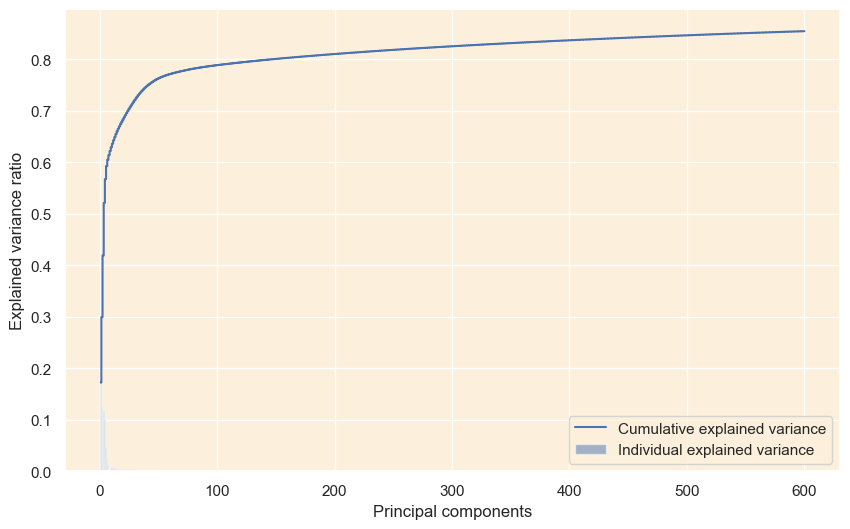

In [61]:
import matplotlib.pyplot as plt

# Variance plot
plt.figure(figsize=(10, 6))
plt.bar(range(1, 601), explained_variance, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, 601), cumulative_variance, where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show()

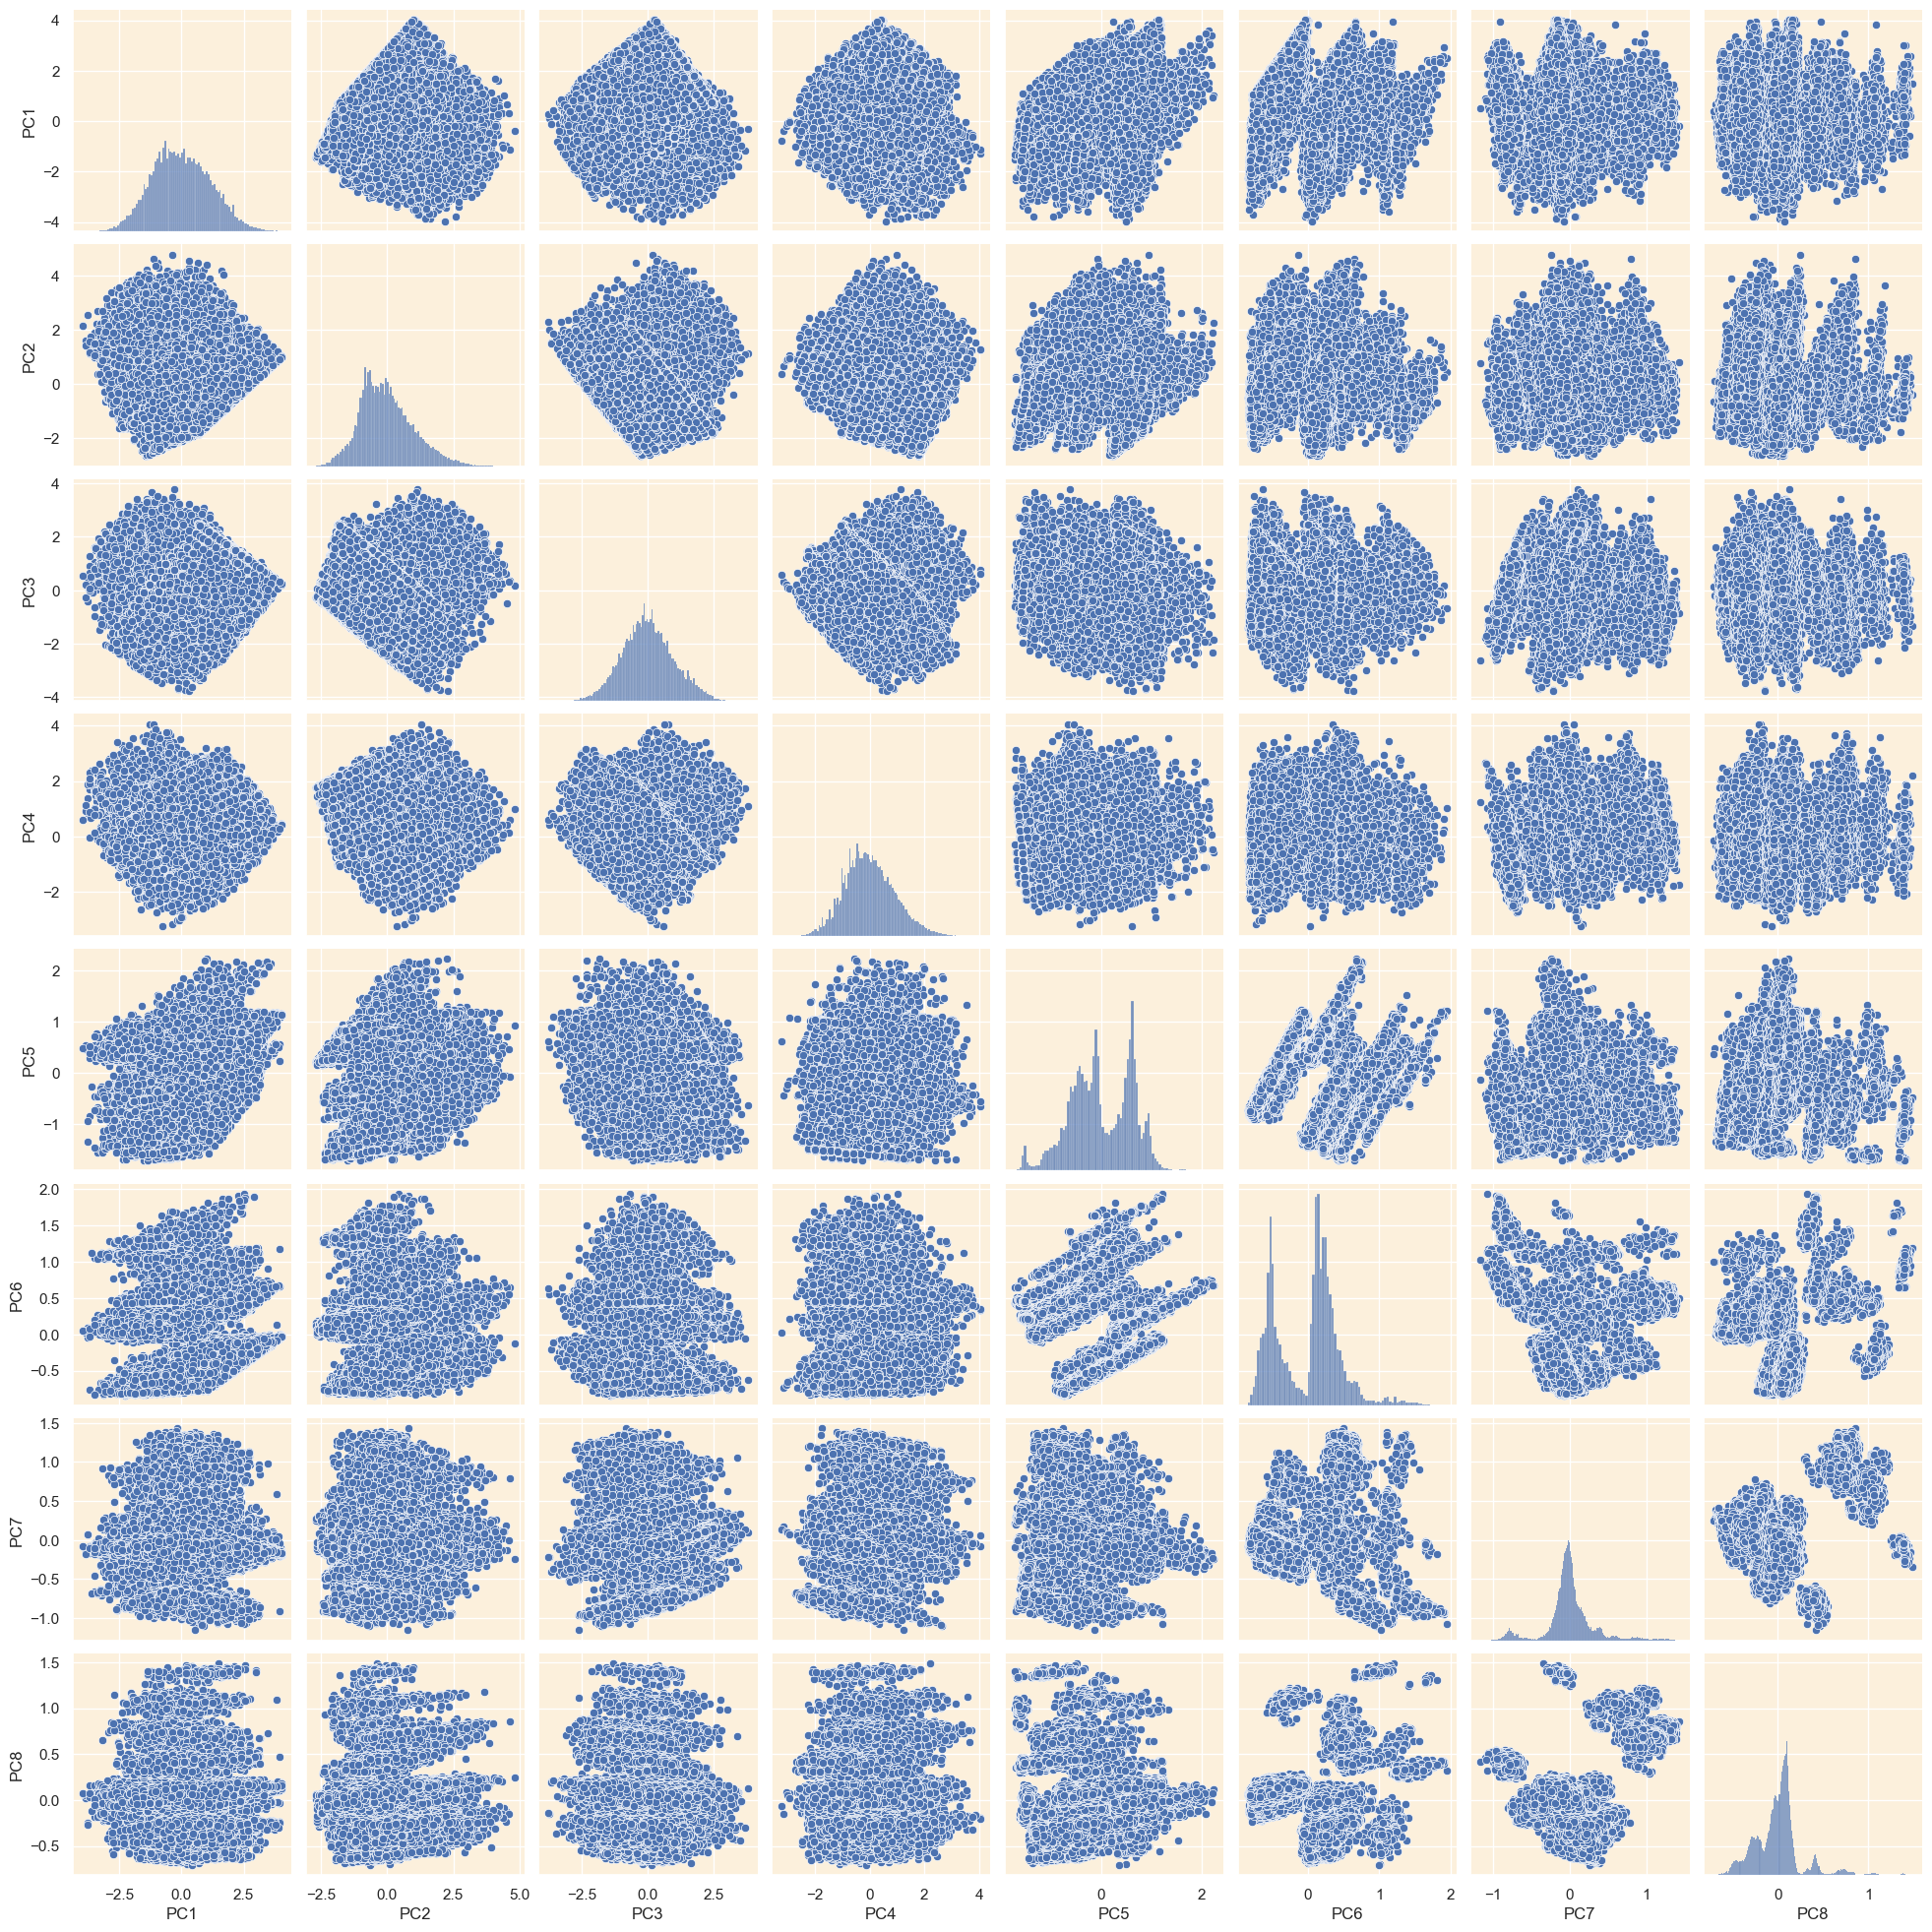

In [62]:
import seaborn as sns

# Pairplot for the first 8 principal components
sns.pairplot(pca_df.iloc[:, :8])
plt.show()

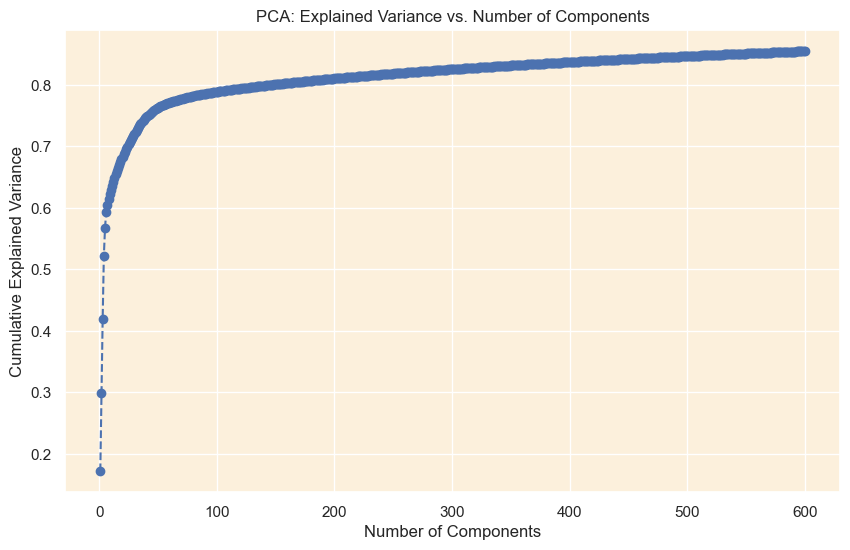

In [63]:
# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA: Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

# 7. k-means Clustering

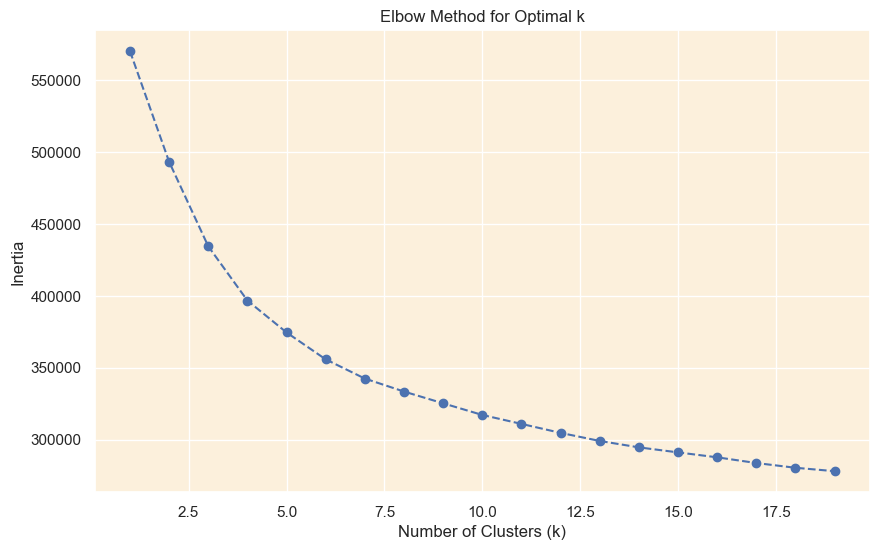

In [64]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Use the first n components from your PCA (e.g., 10 or 15)
n_components = 600  # Adjust based on your PCA results
X_pca = pca_df.iloc[:, :n_components]

# Determine the optimal number of clusters using the elbow method
inertia = []
K = range(1, 20)  # Test between 1 and 20 clusters
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K, inertia, 'bo-', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

In [65]:
# Apply K-Means clustering with the chosen number of clusters
optimal_k = 6  # Example value, replace with your chosen k
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(X_pca)

# Add the cluster labels to your PCA DataFrame
pca_df['Cluster'] = clusters

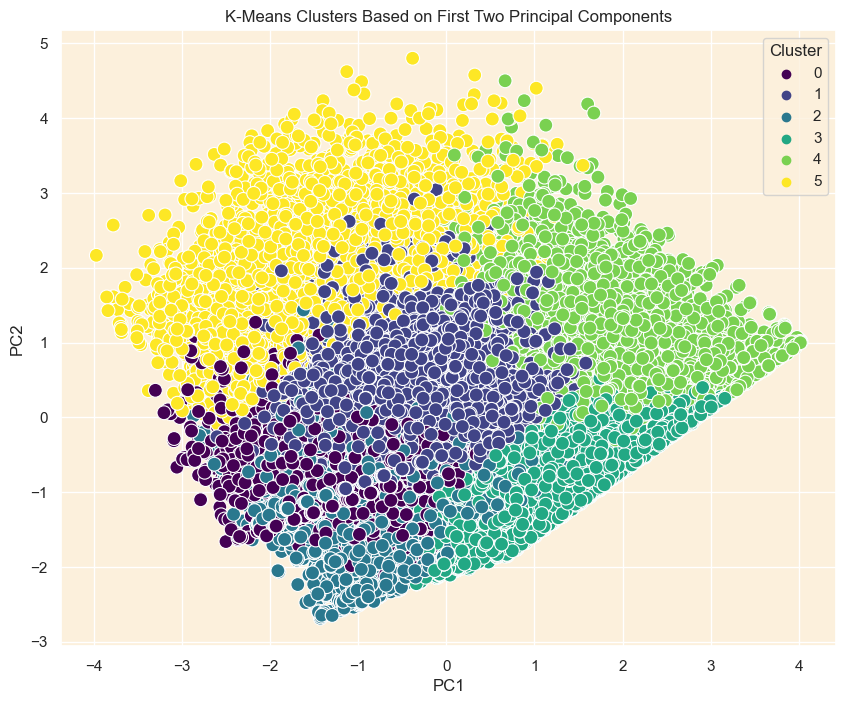

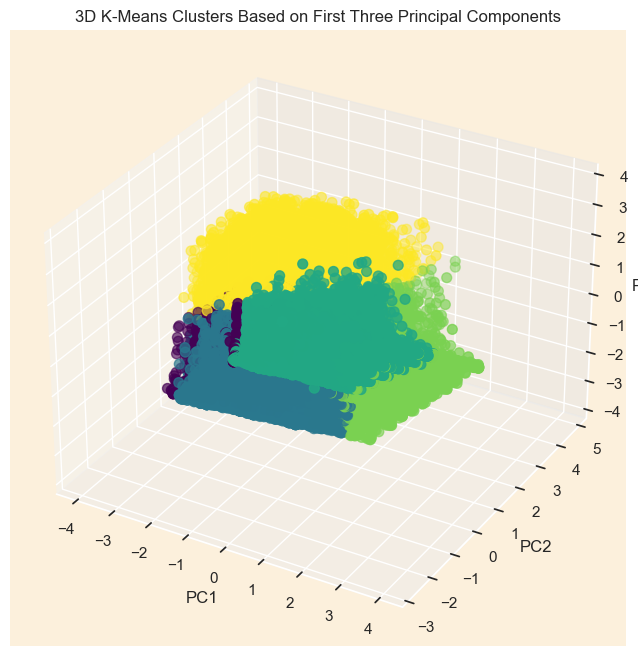

In [66]:
import seaborn as sns

# 2D Plot of the clusters based on the first two principal components
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='viridis', s=100)
plt.title('K-Means Clusters Based on First Two Principal Components')
plt.show()

# 3D Plot (if you want to use three components)
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], c=pca_df['Cluster'], cmap='viridis', s=50)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title('3D K-Means Clusters Based on First Three Principal Components')
plt.show()

# 8. Building Recommendation System-- Clustering 

## 8.1 Building Recommendation System based on k-means

In [67]:
# Check the size of each cluster
df['cluster'] = kmeans.labels_

# Check the size of each cluster
cluster_counts = df['cluster'].value_counts()
print(cluster_counts)

# View a few examples from each cluster
for cluster_num in range(kmeans.n_clusters):
    print(f"Cluster {cluster_num} samples:")
    print(df[df['cluster'] == cluster_num].head())

1    20561
0    16031
3    15585
2    11908
5    10150
4     9149
Name: cluster, dtype: int64
Cluster 0 samples:
          asin                                              title  \
10  B0B69SQNJY    A Little Pinprick (Rainey Paxton Series Book 1)   
19  B0C4Q6K148  Beyond the Game: A Surprise Pregnancy Sports R...   
53  B07P1J7P71                   The Pale-Faced Lie: A True Story   
63  B0BGDDBD58  Recovery from Narcissistic Abuse, Gaslighting,...   
64  B0B9189Z8H  Made For You: A grumpy sunshine sports romance...   

             author                   soldBy  \
10     Paige Dearth  Amazon.com Services LLC   
19      Susan Renee  Amazon.com Services LLC   
53       David Crow  Amazon.com Services LLC   
63       Linda Hill  Amazon.com Services LLC   
64  Natasha Madison  Amazon.com Services LLC   

                                               imgUrl  \
10  https://m.media-amazon.com/images/I/71GoPR+P0e...   
19  https://m.media-amazon.com/images/I/81LrBdKfnQ...   
53  https://

In [68]:
def recommend_items(item_id, df, n_recommendations=5):
    # Get the cluster of the given item
    item_cluster = df.loc[df['asin'] == item_id, 'cluster'].values[0]
    
    # Find other items in the same cluster
    similar_items = df[df['cluster'] == item_cluster]
    
    # Exclude the item itself from the recommendations
    similar_items = similar_items[similar_items['asin'] != item_id]
    
    # Sort by a metric (e.g., rating) and select top N recommendations
    recommendations = similar_items.sort_values(by='stars', ascending=False).head(n_recommendations)
    
    return recommendations

# Example usage
item_id = 'B00AEBEQUK'  # Replace with an actual ASIN or item identifier from your dataset
recommended_items = recommend_items(item_id, df)
print(recommended_items[['title', 'author', 'stars']])

                                                   title  \
74881  Crónicas Germanas: Tomo I (Casos reales docume...   
1828   Black Women and Narcissists: Refuse to be Abus...   
3582               Весь Александр Дюма (Russian Edition)   
22350  Asentir: La magia de mi alma rota (Spanish Edi...   
22181  Lazos de Sangre: Memorias de una Familia Salva...   

                          author  stars  
74881           Igor Franz Wolff    5.0  
1828                    Nya Love    5.0  
3582              Александр Дюма    5.0  
22350  Brenda Amalia Soto Garcia    5.0  
22181            Lisseth Cornejo    5.0  


## 8.2 Evaluating the Recommendation System based on k-means 

In [83]:
# Dummy example: let's say we know users liked items in cluster 2

true_positives = df[(df['cluster'] == 2) & ((df['isBestSeller'] == True) | (df['isEditorsPick'] == True) | (df['isGoodReadsChoice'] == True))]

print(f"True positives (best sellers, editors pick and good readerchoice in cluster 2): {len(true_positives)}")

# Precision: How many of the recommended items are actually best sellers?
precision = len(true_positives) / len(df[df['cluster'] == 2])

# Calculate precision
print(f"Precision of recommendations: {precision:.2f}")

True positives (best sellers, editors pick and good readerchoice in cluster 2): 657
Precision of recommendations: 0.06


In [84]:
# Dummy example: let's say we know users liked items in cluster 3
true_positives = df[(df['cluster'] == 3) & ((df['isBestSeller'] == True) | (df['isEditorsPick'] == True) | (df['isGoodReadsChoice'] == True))]

print(f"True positives (best sellers, editors pick and good readerchoice in cluster 3): {len(true_positives)}")

# Precision: How many of the recommended items are actually Good Readers Choices?
precision = len(true_positives) / len(df[df['cluster'] == 3])

# Calculate precision
print(f"Precision of recommendations: {precision:.2f}")

True positives (best sellers, editors pick and good readerchoice in cluster 3): 531
Precision of recommendations: 0.09


## 8.3 Ajusting the Model 

In [87]:
# Try with a different number of clusters
kmeans = KMeans(n_clusters=20, random_state=42)
kmeans.fit(X_pca)

# Update cluster labels
df['cluster'] = kmeans.labels_

# Re-run recommendations 

def recommend_items(item_id, df, n_recommendations=5):
    # Get the cluster of the given item
    item_cluster = df.loc[df['asin'] == item_id, 'cluster'].values[0]
    
    # Find other items in the same cluster
    similar_items = df[df['cluster'] == item_cluster]
    
    # Exclude the item itself from the recommendations
    similar_items = similar_items[similar_items['asin'] != item_id]
    
    # Sort by a metric (e.g., rating) and select top N recommendations
    recommendations = similar_items.sort_values(by='stars', ascending=False).head(n_recommendations)
    
    return recommendations

# Example usage
item_id = 'B00AEBEQUK'  # Replace with an actual ASIN or item identifier from your dataset
recommended_items = recommend_items(item_id, df)
print(recommended_items[['title', 'author', 'stars']])

                                                   title               author  \
66405  Cook Korean!: A Comic Book with Recipes [A Coo...             Robin Ha   
65597  Danielle Walker's Against All Grain Celebratio...      Danielle Walker   
13462  If This Book Exists, You're in the Wrong Unive...         Jason Pargin   
65776  Amaro: The Spirited World of Bittersweet, Herb...  Brad Thomas Parsons   
10259           The Longmire Defense: A Longmire Mystery        Craig Johnson   

       stars  
66405    4.8  
65597    4.8  
13462    4.8  
65776    4.8  
10259    4.8  


## 8.4 Re-run evaluation

In [88]:
# Dummy example: let's say we know users liked items in cluster 2

true_positives = df[(df['cluster'] == 2) & ((df['isBestSeller'] == True) | (df['isEditorsPick'] == True) | (df['isGoodReadsChoice'] == True))]

print(f"True positives (best sellers in cluster 2): {len(true_positives)}")

# Precision: How many of the recommended items are actually best sellers?
precision = len(true_positives) / len(df[df['cluster'] == 2])

# Calculate precision
print(f"Precision of recommendations: {precision:.2f}")

True positives (best sellers in cluster 2): 350
Precision of recommendations: 0.11


In [89]:
# Dummy example: let's say we know users liked items in cluster 3

true_positives = df[(df['cluster'] == 3) & ((df['isBestSeller'] == True) | (df['isEditorsPick'] == True) | (df['isGoodReadsChoice'] == True))]

print(f"True positives (Good Readers Choice in cluster 3): {len(true_positives)}")

# Precision: How many of the recommended items are actually Good Readers Choices?
precision = len(true_positives) / len(df[df['cluster'] == 3])

# Calculate precision
print(f"Precision of recommendations: {precision:.2f}")

True positives (Good Readers Choice in cluster 3): 158
Precision of recommendations: 0.04


# 9.Building Recommendation System--Content-Based Filtering

## 9.1 Build Content-Based Filtering model

In [74]:
from sklearn.metrics.pairwise import cosine_similarity

# Select features for content-based filtering (e.g., category_id, author, stars, price)
features = df[['category_id', 'stars', 'price']]  # Add more features as needed

# Compute similarity between items
cosine_sim = cosine_similarity(features)

# Function to recommend items based on an item the user likes
def content_based_recommend(item_id, df, cosine_sim, n_recommendations=5):
    idx = df.index[df['asin'] == item_id].tolist()[0]  # Find index of the item
    sim_scores = list(enumerate(cosine_sim[idx]))  # Get similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)  # Sort by similarity
    sim_scores = sim_scores[1:n_recommendations+1]  # Get top N recommendations (excluding itself)
    item_indices = [i[0] for i in sim_scores]
    return df.iloc[item_indices]

# Example usage
item_id = 'B00AEBEQUK'  # Replace with an actual ASIN or item identifier from your dataset
recommended_items = content_based_recommend(item_id, df, cosine_sim)
print(recommended_items[['title', 'author', 'stars']])

                                                title           author  stars
38        The State of Affairs: Rethinking Infidelity     Esther Perel    4.6
39  The Bullet Journal Method: Track the Past, Ord...    Ryder Carroll    4.6
59  Walking with Sam: A Father, a Son, and Five Hu...  Andrew McCarthy    4.6
79  The Book You Wish Your Parents Had Read: (And ...   Philippa Perry    4.6
98  Homecoming: Reclaiming and Healing Your Inner ...    John Bradshaw    4.6


## 9.2 Evaluating Content-Based Filtering model

In [75]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# Generate the test set based on the criterion (books with stars > 3)
test_set = df[df['stars'] > 3]

# Group the test set by users or categories (or any relevant identifier)
test_groups = test_set.groupby('category_id')

# Function to evaluate content-based filtering
def evaluate_content_based(df, test_groups, cosine_sim, n_recommendations=5):
    precision_scores = []
    recall_scores = []
    f1_scores = []

    for category_id, group in test_groups:
        liked_items = group['asin'].tolist()  # Books with stars > 3
        actual_items = df[(df['category_id'] == category_id) & (df['stars'] > 3)]['asin'].tolist()  # Ground truth

        recommended_items = []
        for item_id in liked_items:
            recommendations = content_based_recommend(item_id, df, cosine_sim, n_recommendations)
            recommended_items.extend(recommendations['asin'].tolist())

        # Convert to sets to find intersection
        recommended_items_set = set(recommended_items)
        actual_items_set = set(actual_items)

        # Calculate precision, recall, and F1-score
        true_positives = recommended_items_set & actual_items_set
        precision = len(true_positives) / len(recommended_items_set) if recommended_items_set else 0
        recall = len(true_positives) / len(actual_items_set) if actual_items_set else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        # Store scores
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)

    # Average scores across all test cases
    avg_precision = np.mean(precision_scores)
    avg_recall = np.mean(recall_scores)
    avg_f1 = np.mean(f1_scores)

    print(f"Average Precision: {avg_precision:.2f}")
    print(f"Average Recall: {avg_recall:.2f}")
    print(f"Average F1-Score: {avg_f1:.2f}")

# Cosine_sim is already computed and df is original DataFrame
evaluate_content_based(df, test_groups, cosine_sim)

Average Precision: 0.61
Average Recall: 0.46
Average F1-Score: 0.50


# 10.Conclusion and recommendations

### 10.1 Data Resource

	Kaggle.com/ Amazon Kindle Books Dataset
    Amazon Kindle Books Dataset 2023 (130K Books)

### 10.2 Cleaning Data

  I checked the data and found that there are some NaN values in “author”,”soldBy” and “publishedDate” columns. After calculating the percentage of missing values for each column, I handled missing values and used function to remove outliers based on IQR.There are no duplicate rows.
  
### 10.3 data Exploratory Data Analysis
  
  I made a heatmap of the data to get correlation_matrix. The scatterplot  displayed the distribution of the numerical columns. Regplot displayed  relationships among variables.
  
### 10.4 Data pre-processing and PCA
 
 I used StandardScaler to scale data. Df_scaled has 50551 columns.
 
 I used PCA to reduce dimensionality.
 
### 10.5 Modelling and Evaluation

   I built recommendation system using k-means and Content-Based Filtering.
   From the effect point of view, the content-based filtering algorithm is more effective. The system can recommend several or more books to readers who have already purchased books of this type based on the similarity of the content, thus achieving more sales.

### 10.6 Advice

   If more data on consumers’ book purchases can be obtained, personalized recommendations can be made based on consumers’ behavioral characteristics. If conditions permit, the recommendation system can be used in actual sales, and the effectiveness of the recommendation system can be further evaluated using A/B testing.